<a href="https://colab.research.google.com/github/monci-mamachan628/Pneumonia_/blob/main/NCS_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Implement a deep-learning pipeline for classification of pneumonia in X-Ray Images.

# INTRODUCTION
Pneumonia is a significant health concern worldwide, leading to severe respiratory issues and even death if not diagnosed and treated promptly.The World Health Organization recognizes pneumonia as a leading cause of mortality, predominantly among children and the elderly.While prompt and accurate diagnosis is critical for effective intervention, conventional diagnostic methods are hampered by their inherent limitations: they are resource-intensive, time-consuming, and heavily reliant on the availability of specialized radiological expertise.Chest X-ray images are a common diagnostic tool used by radiologists to detect pneumonia. However, manual interpretation of these images can be time-consuming and prone to human error, especially under high workloads. Automating the detection of pneumonia using deep learning techniques can assist radiologists in making quicker and more accurate diagnoses.

# Challenges:
Developing an automated pneumonia detection system using deep learning faces several challenges:

Data Imbalance: The dataset often contains significantly more images of one class (e.g., normal) than the other (e.g., pneumonia), leading to biased model predictions.
Data Quality and Variability: X-ray images can vary in quality and appearance due to differences in equipment, patient positioning, and other factors.
Model Generalization: Ensuring the model generalizes well to new, unseen data is critical to its clinical applicability.

# Solution:
 This project proposes a deep learning approach using convolutional neural networks (CNNs) to automate the detection of pneumonia from chest X-ray images. The solution involves:

Advanced data preprocessing and augmentation techniques to enhance model robustness. Handling class imbalance through resampling strategies.
Fine-tuning pre-trained CNN architectures, VGG-16 and ResNet-50, for the classification task.
Implementing ensemble learning and hyperparameter tuning to improve model performance.

In [ ]:
import os
import yaml
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.models import vgg16, resnet50
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image, ImageOps
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import copy
import random
import time
import platform
import psutil

# Set random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_seed()
config = {
    'data_dir': '/content/drive/MyDrive/Project/chest_xray/chest_xray',
    'batch_size': 32,
    'num_epochs': 5,
    'learning_rate': 1e-3,
    'momentum': 0.9,
    'k_folds': 10,
    'augment': True,
    'num_estimators': 5,
    'save_path': 'best_model.pth'
}

with open('config.yaml', 'w') as file:
    yaml.dump(config, file)


The PneumoniaDataset class is designed to load and preprocess chest X-ray images for pneumonia detection. It includes optional data augmentation to increase the robustness of the model.The data_transforms dictionary defines the transformations to be applied to the training, validation, and test datasets. These transformations help improve the model's ability to generalize by artificially increasing the diversity of the training data.

In [ ]:
class PneumoniaDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment=False):
        self.root_dir = root_dir
        self.transform = transform
        self.augment = augment
        self.samples = []
        for label in ['NORMAL', 'PNEUMONIA']:
            label_dir = os.path.join(root_dir, label)
            for file in os.listdir(label_dir):
                self.samples.append((os.path.join(label_dir, file), 0 if label == 'NORMAL' else 1))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        image = ImageOps.equalize(image)  # Histogram Equalization
        if self.transform:
            image = self.transform(image)
        if self.augment:
            image = self.apply_augmentation(image)
        return image, label
# Data augmentation and normalization
    def apply_augmentation(self, image):
        augment_transforms = transforms.Compose([
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        ])
        return augment_transforms(image)


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    'val':  transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ]),
    'test':   transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


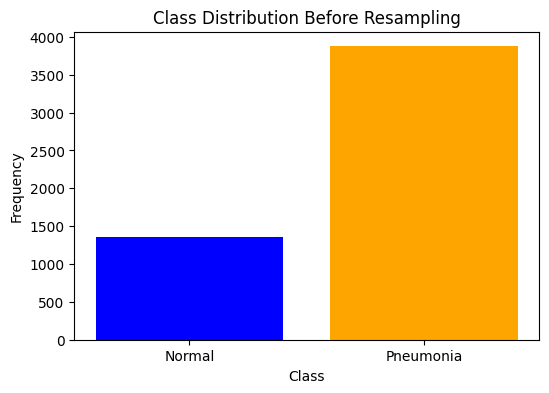

In [ ]:
# Load datasets
data_dir = config['data_dir']
train_dataset = PneumoniaDataset(root_dir=os.path.join(data_dir, 'train'), transform=data_transforms['train'], augment=True)
val_dataset = PneumoniaDataset(root_dir=os.path.join(data_dir, 'val'), transform=data_transforms['val'])
test_dataset = PneumoniaDataset(root_dir=os.path.join(data_dir, 'test'), transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# plot class distribution

def plot_class_distribution(dataset, title='Class Distribution'):
    labels = [label for _, label in dataset.samples]
    counter = Counter(labels)
    plt.figure(figsize=(6, 4))
    plt.bar(counter.keys(), counter.values(), color=['blue', 'orange'])
    plt.xticks([0, 1], ['Normal', 'Pneumonia'])
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

# Visualize class distribution before resampling
plot_class_distribution(train_dataset, title='Class Distribution Before Resampling')

This code designes to resample imblanced chest xray dataset using the SMOTE alogorithm, where NORMAL has significantly more samples than the other which can negatively impact the performance of machine learning models.


Original class distribution: Counter({1: 3875, 0: 1357})
Resampled class distribution - Counter({0: 3875, 1: 3875})
Number of resampled samples: 7750


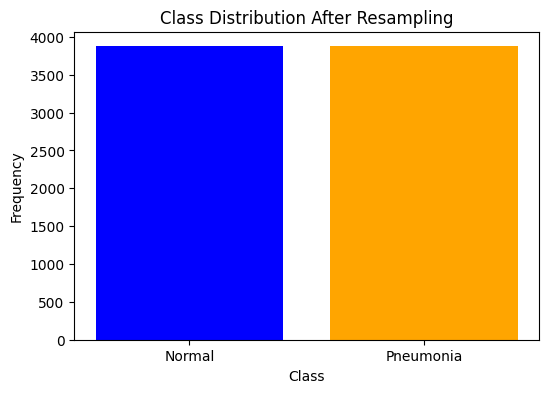

In [ ]:
import os
from collections import Counter
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader


# Function to resample the dataset
def resample_dataset(dataset):
    labels = [label for _, label in dataset.samples]
    counter = Counter(labels)
    print("Original class distribution:", counter)

    majority_class = max(counter, key=counter.get)
    minority_class = min(counter, key=counter.get)

    # Define the SMOTE oversampler
    oversample = SMOTE(sampling_strategy={minority_class: counter[majority_class]})


    # Load images and corresponding labels
    image_paths = [img_path for img_path, _ in dataset.samples]
    labels = [label for _, label in dataset.samples]

    images = []
    for img_path in image_paths:
        img = Image.open(img_path).convert('RGB').resize((128, 128))
        images.append(np.array(img))

    X = np.array(images)
    y = np.array(labels)

    X_res, y_res = oversample.fit_resample(X.reshape(X.shape[0], -1), y)

    print(f"Resampled class distribution - {Counter(y_res)}")

    # Save resampled images and update dataset
    temp_dir = '/tmp/resampled_images'
    os.makedirs(temp_dir, exist_ok=True)
    resampled_samples = []

    for idx, (x, y) in enumerate(zip(X_res, y_res)):
        x = x.reshape(128, 128, 3)
        img = Image.fromarray(x.astype('uint8'), 'RGB')
        temp_img_path = os.path.join(temp_dir, f'{idx}.png')
        img.save(temp_img_path)
        resampled_samples.append((temp_img_path, y))

    print("Number of resampled samples:", len(resampled_samples))
    return resampled_samples

# Assuming `train_dataset` is defined and is a valid dataset
# Resample the dataset
resampled_samples = resample_dataset(train_dataset)
if resampled_samples:
    train_dataset.samples = resampled_samples
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
else:
    print("Warning: No samples were resampled. Check for errors in the resampling process.")

# Plot the class distribution after resampling
plot_class_distribution(train_dataset, title='Class Distribution After Resampling')


 The total number of resampled samples is now 7750.

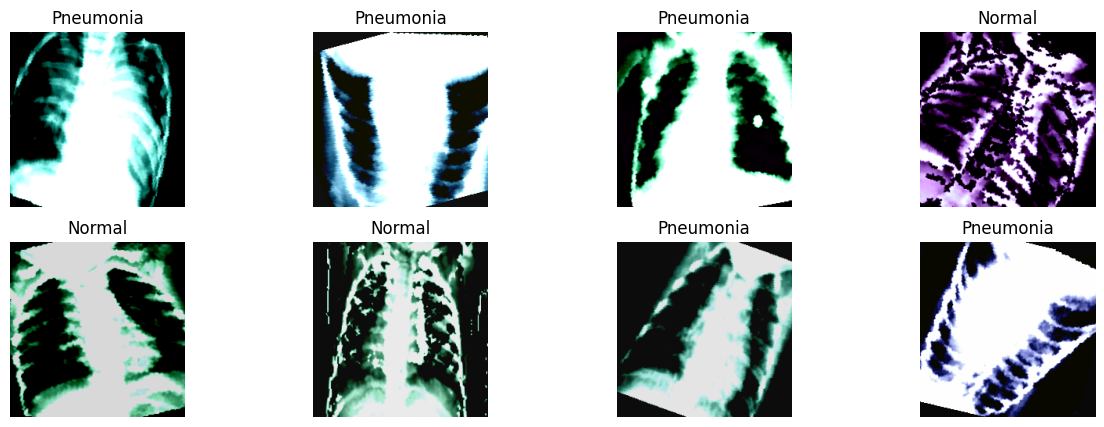

In [ ]:
def show_images(dataset, num_images=8):


    # Get a batch of images
  images, labels = next(iter(train_loader))

    # Plot the images
  plt.figure(figsize=(15, 5))
  for i in range(num_images):
        ax = plt.subplot(2, num_images//2, i + 1)
        plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        plt.title('Normal' if labels[i].item() == 0 else 'Pneumonia')
        plt.axis('off')
  plt.show()
show_images(train_dataset)

These functions handle the training and evaluation of the model, ensuring that the best model weights are saved based on validation accuracy.

In [ ]:
# Model training and evaluation functions
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, dataloaders, num_epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model

This is focused on fine-tuning and evaluating two pre-trained convolutional neural network models, VGG-16 and ResNet-50, for a binary classification task. The goal is to compare the performance of these models on a specific dataset.

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)
    auc_roc = roc_auc_score(all_labels, all_preds, average='weighted', multi_class='ovr')

    return accuracy, precision, recall, f1, auc_roc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Fine-tuning VGG-16
vgg_model = vgg16(pretrained=True)
for param in vgg_model.features.parameters():
    param.requires_grad = False
for param in vgg_model.classifier[:-1].parameters():
    param.requires_grad = True
vgg_model.classifier[6] = nn.Linear(vgg_model.classifier[6].in_features, 2)
vgg_model = vgg_model.to(device)

# Fine-tuning more layers in ResNet-50
resnet_model = resnet50(pretrained=True)
for param in resnet_model.parameters():
    param.requires_grad = True
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 2)
resnet_model = resnet_model.to(device)

dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
 

Epoch 0/1
----------
train Loss: 0.3671 Acc: 0.8276
val Loss: 0.9311 Acc: 0.5000
Epoch 1/1
----------
train Loss: 0.2920 Acc: 0.8671
val Loss: 0.8224 Acc: 0.4375
Epoch 0/1
----------
train Loss: 0.2117 Acc: 0.9090
val Loss: 1.7583 Acc: 0.5000
Epoch 1/1
----------
train Loss: 0.1508 Acc: 0.9400
val Loss: 1.8956 Acc: 0.5000
VGG-16 Metrics: (0.6266025641025641, 0.6167609046849757, 0.6266025641025641, 0.4900881605301243, 0.5038461538461538)
ResNet-50 Metrics: (0.47275641025641024, 0.6912173960493289, 0.47275641025641024, 0.4074998297814394, 0.5679487179487179)


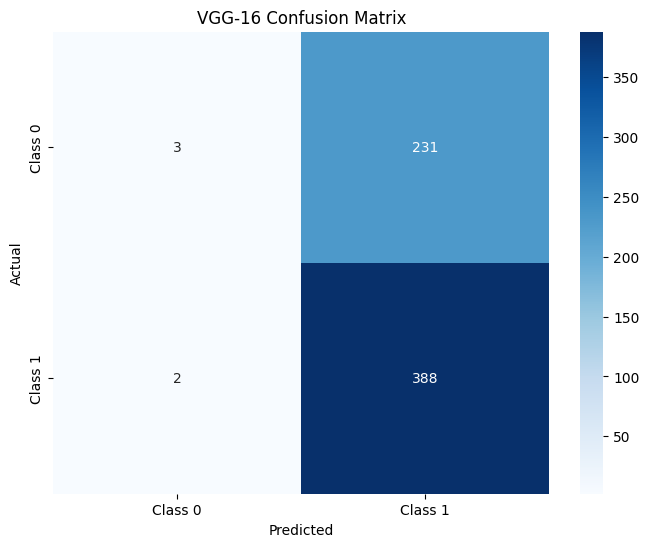

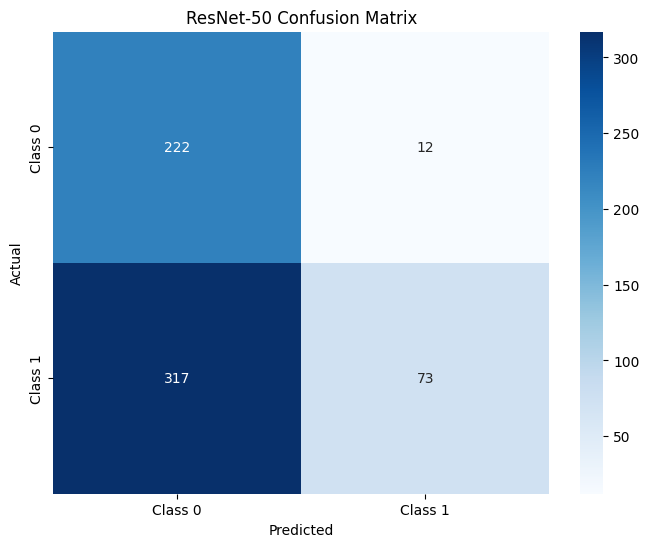

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import vgg16, resnet50
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Updated evaluate_model function to return labels and predictions
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)
    auc_roc = roc_auc_score(all_labels, all_preds, average='weighted', multi_class='ovr')

    return accuracy, precision, recall, f1, auc_roc, all_labels, all_preds

# Assuming device is defined and models are moved to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fine-tuning VGG-16
vgg_model = vgg16(pretrained=True)
for param in vgg_model.features.parameters():
    param.requires_grad = False
for param in vgg_model.classifier[:-1].parameters():
    param.requires_grad = True
vgg_model.classifier[6] = nn.Linear(vgg_model.classifier[6].in_features, 2)
vgg_model = vgg_model.to(device)

# Fine-tuning more layers in ResNet-50
resnet_model = resnet50(pretrained=True)
for param in resnet_model.parameters():
    param.requires_grad = True
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 2)
resnet_model = resnet_model.to(device)

# Assuming train_loader, val_loader, and test_loader are defined
dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

criterion = nn.CrossEntropyLoss()

# Define optimizers
vgg_optimizer = torch.optim.SGD(vgg_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
resnet_optimizer = torch.optim.AdamW(resnet_model.parameters(), lr=1e-4, weight_decay=1e-4)

# Assuming train_model is defined and correctly trains the model
vgg_model = train_model(vgg_model, criterion, vgg_optimizer, dataloaders, num_epochs=2)
resnet_model = train_model(resnet_model, criterion, resnet_optimizer, dataloaders, num_epochs=2)

# Evaluate models
vgg_accuracy, vgg_precision, vgg_recall, vgg_f1, vgg_auc_roc, vgg_labels, vgg_preds = evaluate_model(vgg_model, test_loader)
resnet_accuracy, resnet_precision, resnet_recall, resnet_f1, resnet_auc_roc, resnet_labels, resnet_preds = evaluate_model(resnet_model, test_loader)

# Combine metrics into tuples for easier printing
vgg_metrics = (vgg_accuracy, vgg_precision, vgg_recall, vgg_f1, vgg_auc_roc)
resnet_metrics = (resnet_accuracy, resnet_precision, resnet_recall, resnet_f1, resnet_auc_roc)

print(f'VGG-16 Metrics: {vgg_metrics}')
print(f'ResNet-50 Metrics: {resnet_metrics}')

# Plot confusion matrices
def plot_confusion_matrix(labels, preds, title):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot confusion matrices for both models
plot_confusion_matrix(vgg_labels, vgg_preds, 'VGG-16 Confusion Matrix')
plot_confusion_matrix(resnet_labels, resnet_preds, 'ResNet-50 Confusion Matrix')


**k-fold cross-validation** to evaluate the performance of two pre-trained convolutional neural network models, VGG-16 and ResNet-50, on a given dataset. Cross-validation is a technique used to assess the generalization ability of a model and ensure that the model's performance is not biased by a specific split of the dataset into training and validation sets.

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset

def k_fold_cross_validation(model, dataset, criterion, optimizer, k=10, num_epochs=10):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    metrics = []

    for fold, (train_index, val_index) in enumerate(kf.split(dataset)):
        print(f"Fold {fold + 1}/{k}")

        train_subset = Subset(dataset, train_index)
        val_subset = Subset(dataset, val_index)

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

        dataloaders = {'train': train_loader, 'val': val_loader}

        model = train_model(model, criterion, optimizer, dataloaders, num_epochs)
        accuracy, precision, recall, f1, auc_roc, _, _ = evaluate_model(model, val_loader)

        print(f"Fold {fold + 1} Metrics: {accuracy, precision, recall, f1, auc_roc}")

        metrics.append((accuracy, precision, recall, f1, auc_roc))

    # Convert list of tuples to numpy array for averaging
    metrics_array = np.array(metrics)
    avg_metrics = np.mean(metrics_array, axis=0)

    return avg_metrics

# Example usage with VGG-16 and ResNet-50
vgg_avg_metrics = k_fold_cross_validation(vgg_model, train_dataset, criterion, vgg_optimizer, k=2, num_epochs=2)
print(f'VGG-16 K-Fold Cross-Validation Metrics: {vgg_avg_metrics}')

resnet_avg_metrics = k_fold_cross_validation(resnet_model, train_dataset, criterion, resnet_optimizer, k=2, num_epochs=2)
print(f'ResNet-50 K-Fold Cross-Validation Metrics: {resnet_avg_metrics}')


Fold 1/2
Epoch 0/1
----------
train Loss: 0.2281 Acc: 0.9012
val Loss: 0.2198 Acc: 0.9112
Epoch 1/1
----------
train Loss: 0.2148 Acc: 0.9079
val Loss: 0.2101 Acc: 0.9099
Fold 1 Metrics: (0.9078709677419354, 0.9082560073951778, 0.9078709677419354, 0.907852864872269, 0.9079058341143018)
Fold 2/2
Epoch 0/1
----------
train Loss: 0.2303 Acc: 0.8991
val Loss: 0.2003 Acc: 0.9169
Epoch 1/1
----------
train Loss: 0.2211 Acc: 0.9030
val Loss: 0.1950 Acc: 0.9208
Fold 2 Metrics: (0.9220645161290323, 0.9226415439292825, 0.9220645161290323, 0.922034233111921, 0.9220209404334602)
VGG-16 K-Fold Cross-Validation Metrics: [0.91496774 0.91544878 0.91496774 0.91494355 0.91496339]
Fold 1/2
Epoch 0/1
----------
train Loss: 0.1658 Acc: 0.9339
val Loss: 0.1316 Acc: 0.9497
Epoch 1/1
----------
train Loss: 0.1387 Acc: 0.9417
val Loss: 0.1365 Acc: 0.9517
Fold 1 Metrics: (0.9483870967741935, 0.9501649535796429, 0.9483870967741935, 0.9483320993144966, 0.9483136941292303)
Fold 2/2
Epoch 0/1
----------
train Loss:

Fold 1/2
Epoch 0/1
----------
train Loss: 0.2015 Acc: 0.9130
val Loss: 0.2072 Acc: 0.9055
Epoch 1/1
----------
train Loss: 0.2090 Acc: 0.9141
val Loss: 0.1988 Acc: 0.9151
Fold 1 Metrics: (0.919741935483871, 0.9206211045979948, 0.919741935483871, 0.9196952868193975, 0.9196881578183249)
Fold 2/2
Epoch 0/1
----------
train Loss: 0.2081 Acc: 0.9107
val Loss: 0.1789 Acc: 0.9267
Epoch 1/1
----------
train Loss: 0.2026 Acc: 0.9135
val Loss: 0.1843 Acc: 0.9288
Fold 2 Metrics: (0.9264516129032258, 0.9266579960731257, 0.9264516129032258, 0.9264406587262507, 0.9264254428610779)


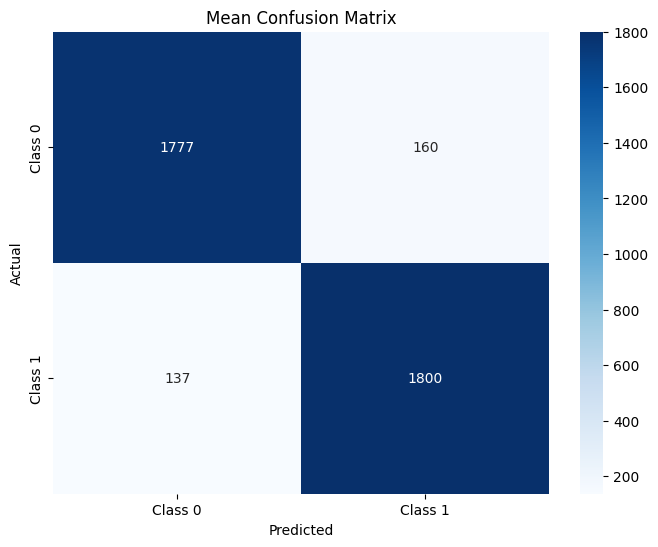

VGG-16 K-Fold Cross-Validation Metrics: [0.92309677 0.92363955 0.92309677 0.92306797 0.9230568 ]
Fold 1/2
Epoch 0/1
----------
train Loss: 0.1043 Acc: 0.9603
val Loss: 0.0867 Acc: 0.9646
Epoch 1/1
----------
train Loss: 0.0983 Acc: 0.9610
val Loss: 0.0962 Acc: 0.9636
Fold 1 Metrics: (0.9667096774193549, 0.9668814051428442, 0.9667096774193549, 0.966707380440373, 0.9667316748564021)
Fold 2/2
Epoch 0/1
----------
train Loss: 0.0882 Acc: 0.9662
val Loss: 0.1567 Acc: 0.9368
Epoch 1/1
----------
train Loss: 0.1224 Acc: 0.9499
val Loss: 0.1082 Acc: 0.9559
Fold 2 Metrics: (0.9636129032258065, 0.9638025102094658, 0.9636129032258065, 0.9636100678156856, 0.9636360827153515)


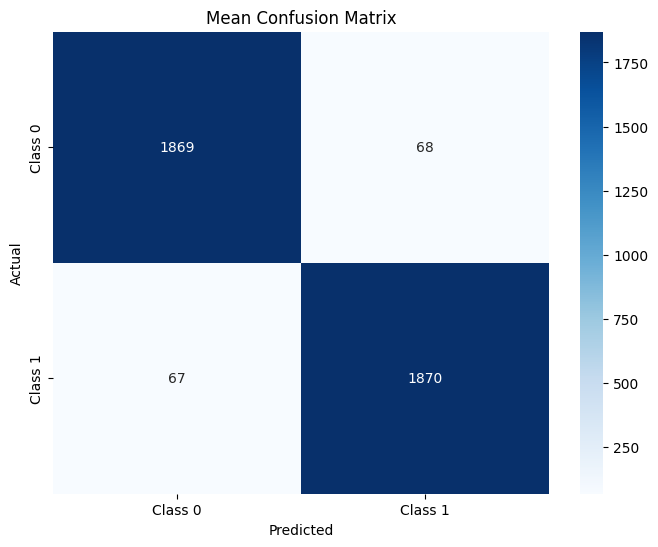

ResNet-50 K-Fold Cross-Validation Metrics: [0.96516129 0.96534196 0.96516129 0.96515872 0.96518388]


In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def k_fold_cross_validation(model, dataset, criterion, optimizer, k=10, num_epochs=10):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    metrics = []
    confusion_matrices = []

    for fold, (train_index, val_index) in enumerate(kf.split(dataset)):
        print(f"Fold {fold + 1}/{k}")

        train_subset = Subset(dataset, train_index)
        val_subset = Subset(dataset, val_index)

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

        dataloaders = {'train': train_loader, 'val': val_loader}

        model = train_model(model, criterion, optimizer, dataloaders, num_epochs)
        accuracy, precision, recall, f1, auc_roc, labels, preds = evaluate_model(model, val_loader)

        print(f"Fold {fold + 1} Metrics: {accuracy, precision, recall, f1, auc_roc}")

        metrics.append((accuracy, precision, recall, f1, auc_roc))
        confusion_matrices.append(confusion_matrix(labels, preds))

    # Convert list of tuples to numpy array for averaging
    metrics_array = np.array(metrics)
    avg_metrics = np.mean(metrics_array, axis=0)

    # Compute mean confusion matrix
    mean_cm = np.mean(confusion_matrices, axis=0).astype(int)
    plot_confusion_matrix(mean_cm, 'Mean Confusion Matrix')

    return avg_metrics

# Example usage with VGG-16 and ResNet-50
vgg_avg_metrics = k_fold_cross_validation(vgg_model, train_dataset, criterion, vgg_optimizer, k=2, num_epochs=2)
print(f'VGG-16 K-Fold Cross-Validation Metrics: {vgg_avg_metrics}')

resnet_avg_metrics = k_fold_cross_validation(resnet_model, train_dataset, criterion, resnet_optimizer, k=2, num_epochs=2)
print(f'ResNet-50 K-Fold Cross-Validation Metrics: {resnet_avg_metrics}')


After completing the k-fold cross-validation process, the function calculates the average metrics across all folds and returns them. he k_fold_cross_validation function is called twice, once for the VGG-16 model and once for the ResNet-50 model. The average metrics for each model are printed, allowing for a comparison of their performance using k-fold cross-validation.






Bagging is an ensemble learning technique that combines multiple models to improve the overall performance and stability of the predictions. Bootstrap aggregating (bagging) by training multiple instances of VGG-16 and ResNet-50 models on different random subsets of the training dataset. Each model is evaluated, and their predictions are aggregated.

The log_model_performance function prints the metrics,such as detailing accuracy, precision, recall, F1 score, and AUC-ROC. while the log_model_params_and_device function focuses on model parameters and hardware profile.

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision.models import vgg16, resnet50
from torch.utils.data import DataLoader, Dataset, Subset
import copy
import random

# Set random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()

# Define the number of models to train
num_estimators = 5

# Define the bagging process
def bootstrap_resample(dataset, num_samples=None):
    if num_samples is None:
        num_samples = len(dataset)
    indices = torch.randint(high=len(dataset), size=(num_samples,))
    return Subset(dataset, indices)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to train and return a list of models
def train_ensemble(num_estimators, model_type, dataset, criterion, optimizer_cls, num_epochs=2):
    models = []
    optimizers = []

    for i in range(num_estimators):
        print(f'Training model {i + 1}/{num_estimators}')

        # Resample the dataset
        resampled_dataset = bootstrap_resample(dataset)
        # Reduced batch size to 16
        train_loader = DataLoader(resampled_dataset, batch_size=16, shuffle=True) # Reduced batch size

        # Initialize model
        if model_type == 'vgg16':
            model = vgg16(pretrained=True)
            for param in model.features.parameters():
                param.requires_grad = False
            for param in model.classifier[:-1].parameters():
                param.requires_grad = True
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
        elif model_type == 'resnet50':
            model = resnet50(pretrained=True)
            for param in model.parameters():
                param.requires_grad = True
            model.fc = nn.Linear(model.fc.in_features, 2)

        # Move model to device in smaller steps
        for module in model.children():
            module = module.to(device)

        optimizer = optimizer_cls(model.parameters())

        # Train the model
        model = train_model(model, criterion, optimizer, {'train': train_loader, 'val': val_loader}, num_epochs)

        # Save the model and optimizer
        models.append(model)
        optimizers.append(optimizer)

    return models, optimizers

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
vgg_optimizer_cls = lambda params: torch.optim.SGD(params, lr=1e-3, momentum=0.9, weight_decay=1e-4)
resnet_optimizer_cls = lambda params: torch.optim.AdamW(params, lr=1e-4, weight_decay=1e-4)

# Train ensemble of VGG-16 and ResNet-50 models
vgg_models, vgg_optimizers = train_ensemble(num_estimators, 'vgg16', train_dataset, criterion, vgg_optimizer_cls)
resnet_models, resnet_optimizers = train_ensemble(num_estimators, 'resnet50', train_dataset, criterion, resnet_optimizer_cls)

Training model 1/5


OutOfMemoryError: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 

In [ ]:

# Log model performance
def log_model_performance(model_name, metrics, model):
    accuracy, precision, recall, f1, auc_roc = metrics
    print(f'{model_name} Metrics:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'AUC-ROC: {auc_roc:.4f}')

    # Log parameters and hardware profile
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{model_name} Number of trainable parameters: {num_params}')
    print(f'Running on device: {device}')

# Log model parameters and hardware profile
def log_model_params_and_device(model, model_name):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'\n{model_name} Parameters and Hardware Profile:')
    print(f'Number of trainable parameters: {num_params}')
    print(f'Running on device: {device}')


# Save the best model
def save_model(model, path='best_model.pth'):
    torch.save(model.state_dict(), path)




Here we are calculating the Best model by their Accuracy

In [ ]:
import numpy as np

print(f'VGG-16 Metrics: {vgg_avg_metrics}')
print(f'ResNet-50 Metrics: {resnet_avg_metrics}')

# Determine the best model
if resnet_avg_metrics[0] > vgg_avg_metrics[0]:  # Comparing accuracy (assuming it's the first element in the metrics)
    best_model = resnet_model
    best_model_name = "ResNet-50"
    best_metrics = resnet_avg_metrics
else:
    best_model = vgg_model
    best_model_name = "VGG-16"
    best_metrics = vgg_avg_metrics

# Print and log the best model information
print(f'The best model is {best_model_name}')
log_model_performance(best_model_name, best_metrics, best_model)
log_model_params_and_device(best_model, best_model_name)
save_model(best_model, f'{best_model_name.lower()}_model.pth')


VGG-16 Metrics: [0.92309677 0.92363955 0.92309677 0.92306797 0.9230568 ]
ResNet-50 Metrics: [0.96516129 0.96534196 0.96516129 0.96515872 0.96518388]
The best model is ResNet-50
ResNet-50 Metrics:
Accuracy: 0.9652
Precision: 0.9653
Recall: 0.9652
F1 Score: 0.9652
AUC-ROC: 0.9652
ResNet-50 Number of trainable parameters: 23512130
Running on device: cuda

ResNet-50 Parameters and Hardware Profile:
Number of trainable parameters: 23512130
Running on device: cuda


The inference function predicts the class of a randomly selected image from a given directory using the best trained model. The function returns the predicted label and the image path.The prediction is then displayed with the corresponding class name ('Normal' or 'Pneumonia').


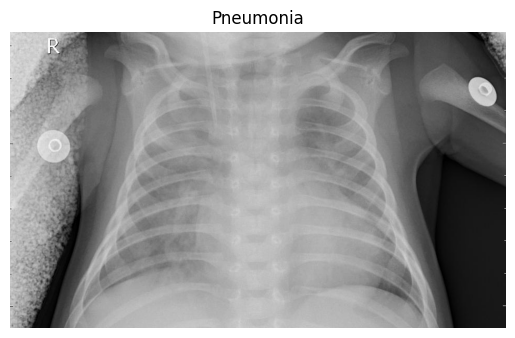

Predicted class: Pneumonia for image /content/drive/MyDrive/Project/chest_xray/chest_xray/test/PNEUMONIA/person82_bacteria_405.jpeg


In [ ]:
def inference(model, image_dir, transform):
    model.eval()
    # Move the model to the same device as the input data
    model.to(device)  # Add this line

    image_files = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_files.append(os.path.join(root, file))

    if not image_files:
        print("No image files found in the directory.")
        return None, None

    random_image_file = random.choice(image_files)
    image = Image.open(random_image_file).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, preds = torch.max(output, 1)

    # Display the image and print the result
    plt.imshow(image)
    plt.axis('off')
    plt.title('Pneumonia' if preds.item() == 1 else 'Normal')
    plt.show()

    return preds.item(), random_image_file

image_dir = "/content/drive/MyDrive/Project/chest_xray/chest_xray/test"
prediction, image_file = inference(vgg_model, image_dir, data_transforms['test'])

if prediction is not None:
    print(f'Predicted class: {"Pneumonia" if prediction == 1 else "Normal"} for image {image_file}')
else:
    print("Inference failed. Check the image directory and transform.")